# ITChromo -> Identificação de Cromossomos utilizando "Segment Anything" (Meta)

- Repositório Modelo -> https://github.com/facebookresearch/segment-anything<br/>

- Para instalação do modelo, utilizar: "pip install git+https://github.com/facebookresearch/segment-anything.git"

In [1]:
# Conjunto de Importações
import cv2
import random
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches

In [2]:
'''
    Antes de utilizarmos o "Segment Anything" localmente, devemos baixar o seu modelo e seus datasets de treinamento.
    Para isso, baixaremos diretamente do KAGGLE, através da lib "kagglehub" e o "shutil" para movermos o arquivo para o diretório desejado
    Como podemos ver a seguir:
'''

import kagglehub            # -> lib do kaggle
import shutil
import os

# Nome do modelo e caminhos
model_name = "sam_vit_b_01ec64.pth"
model_dir = "./models/segment_anything"
final_model_path = os.path.join(model_dir, model_name)

# Se o modelo final já existe e tem tamanho plausível (>1MB), evita baixar de novo
if os.path.exists(final_model_path) and os.path.getsize(final_model_path) > 1_000_000:
    print(f"✅ Modelo já existe em: {final_model_path}")
else:
    print("⬇️  Tentando baixar modelo vit_b do Segment Anything...")

    # FORÇA o re-download limpando o cache se necessário
    kagglehub_cache = os.path.expanduser("~/.cache/kagglehub")
    if os.path.exists(kagglehub_cache):
        print("🧹 Limpando cache do kagglehub...")
        shutil.rmtree(kagglehub_cache)

    # Tenta baixar novamente
    try:
        model_path = kagglehub.model_download('metaresearch/segment-anything/PyTorch/vit-b/1')
    except Exception as e:
        print(f"❌ Erro ao baixar o modelo: {e}")
        exit(1)

    # Cria diretório final, se necessário
    os.makedirs(model_dir, exist_ok=True)

    # Move e renomeia o arquivo baixado
    moved = False
    for file_name in os.listdir(model_path):
        if file_name.endswith(".pth"):
            src = os.path.join(model_path, file_name)
            dst = os.path.join(model_dir, model_name)
            shutil.copy(src, dst)
            print(f"✅ Modelo salvo como: {dst}")
            moved = True

    if not moved:
        print("❌ Nenhum arquivo .pth encontrado após o download.")


✅ Modelo já existe em: ./models/segment_anything\sam_vit_b_01ec64.pth


In [3]:
# Função Auxiliar para plottagem e visualização das máscaras de cada cromossomo
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0],m.shape[1],3))
        color_mask = np.random.random((1,3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))

In [4]:
# sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth'
sam_checkpoint = os.path.join("./models/segment_anything", "sam_vit_b_01ec64.pth")
model_type = "vit_b"            # tipo do modelo -> vision transformer
device = "cpu"                  # cpu ou cuda

# Inicializa o modelo com o checkpoint correto
# Inicialização do modelo utilizando o checkpoinnt
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Criação do gerador de máscaras
mask_generator1 = SamAutomaticMaskGenerator(sam)

# GERAÇÃO AUTOMÁTICA DE MÁSCARA

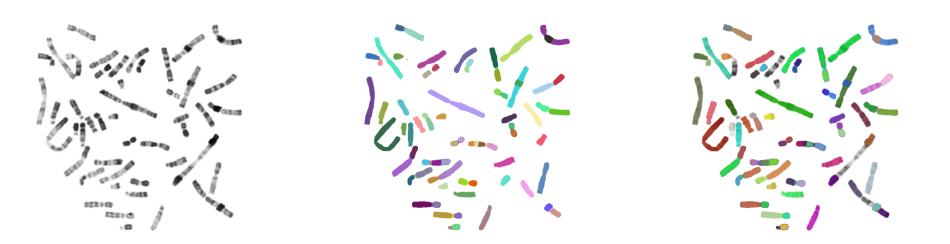

In [5]:
# path0='/kaggle/input/chromosome-image-dataset-karyotype/Data/24_chromosomes_object/JEPG/103064.jpg'
path0='..\datasets\ITChromo\ITChromo-Leo2.png'                                    # TESTE INICIAL COM IMAGEM de FUNDO PRETO
image = cv2.imread(path0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image0,dsize=None,fx=0.1,fy=0.1)

masks1 = mask_generator1.generate(image)

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(image)
axs[2].imshow(image) 
show_anns(masks1,axs[1])
show_anns(masks1,axs[2])
axs[0].axis('off')
axs[1].axis('off')    
axs[2].axis('off')    
plt.show()

In [6]:
# Criação de uma máscara totalmente branca, que será usada como FUNDO NEUTRO para criação de novas máscaras
bgw=np.ones(image.shape)*255
print(len(masks1))                      # quantas máscaras foram detectadas (cada máscara é um dicionário)
print(masks1[0].keys())                 # acessa o dicionário da primeira máscara

87
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


(741, 902, 3)


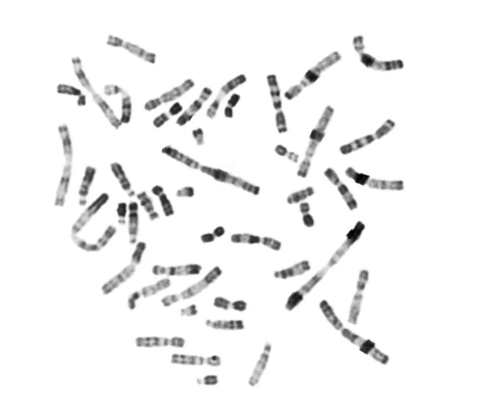

In [7]:
print(image.shape)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off') 
plt.show()

## Cortes de máscara da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


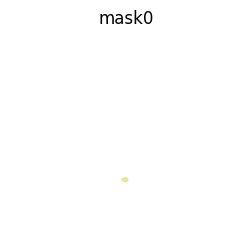

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


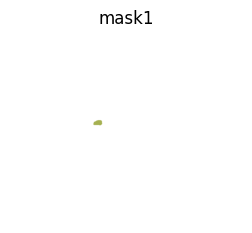

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


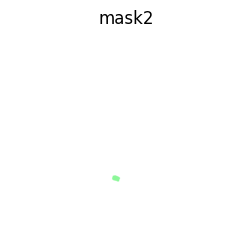

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


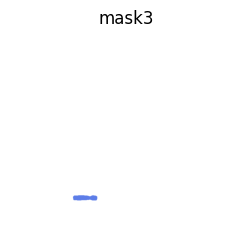

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


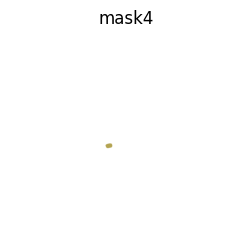

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


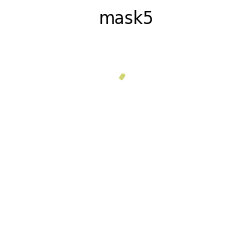

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


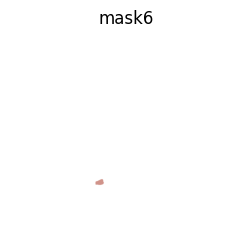

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


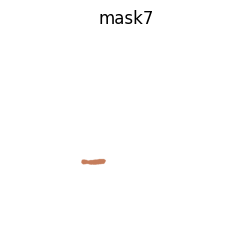

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


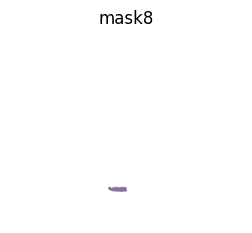

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


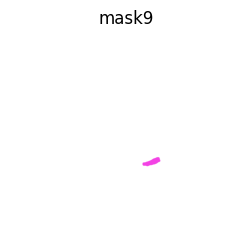

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


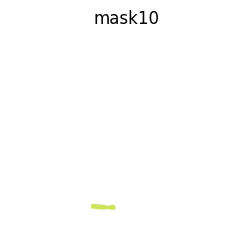

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


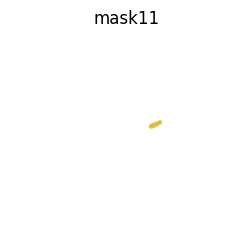

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


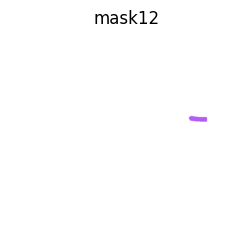

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


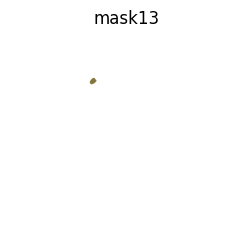

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


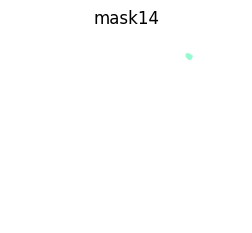

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


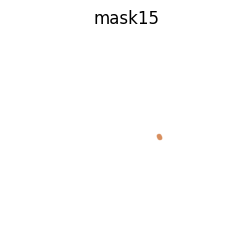

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


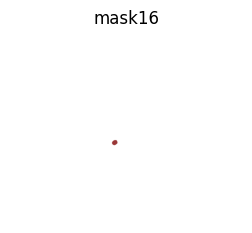

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


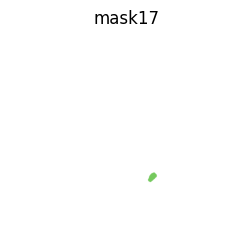

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


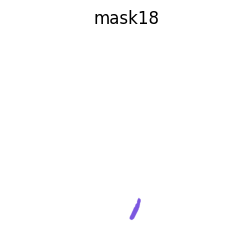

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


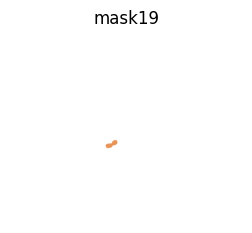

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


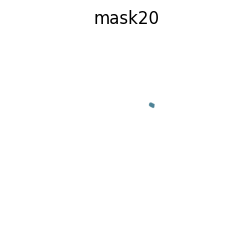

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


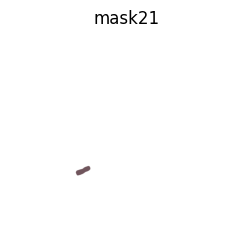

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


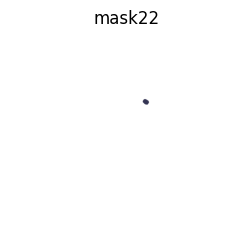

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


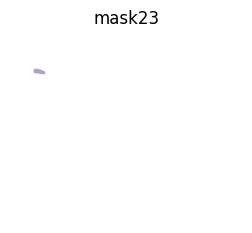

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


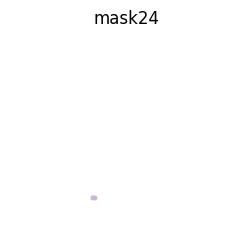

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


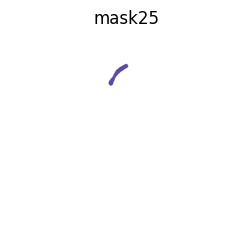

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


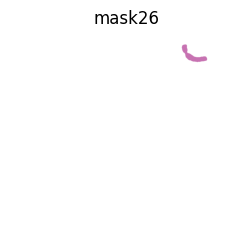

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


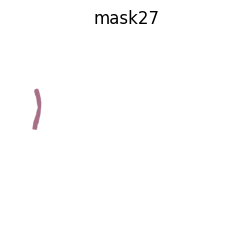

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


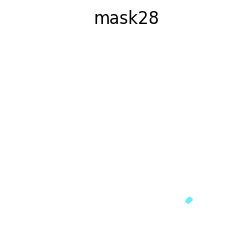

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


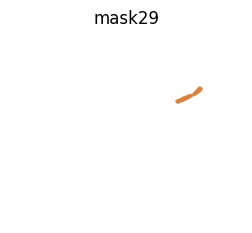

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


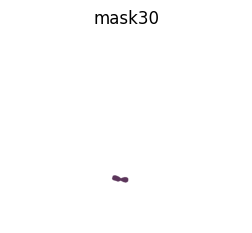

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


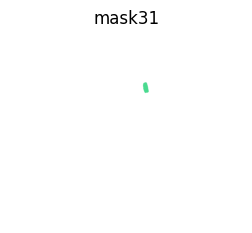

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


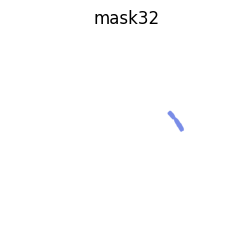

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


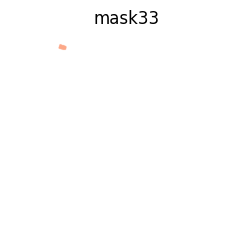

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


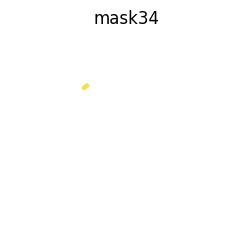

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


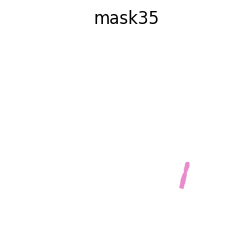

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


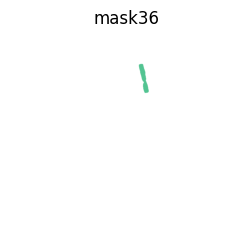

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


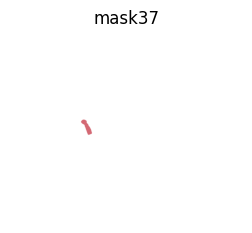

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


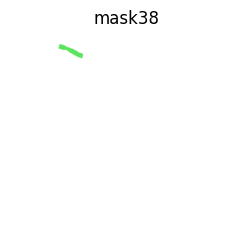

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


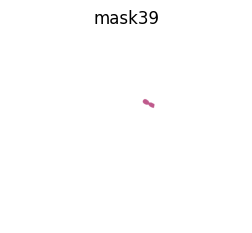

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


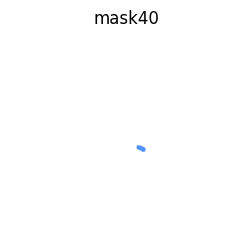

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


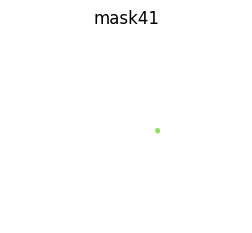

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


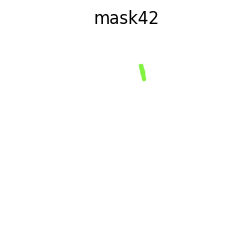

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


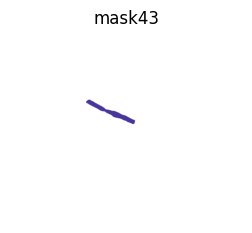

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


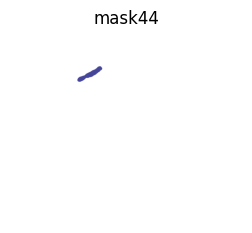

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


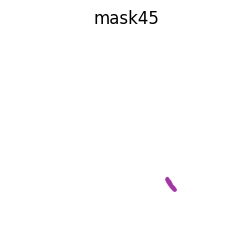

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


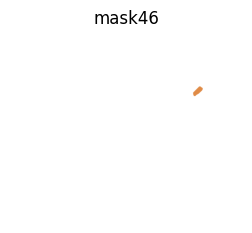

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


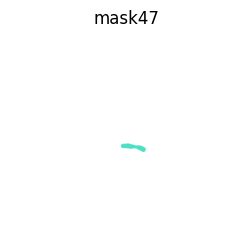

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


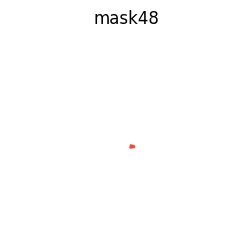

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


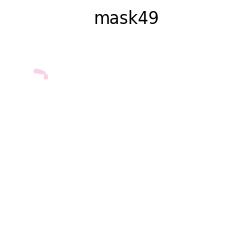

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


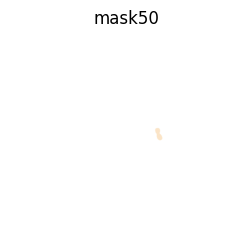

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


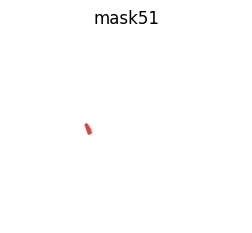

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


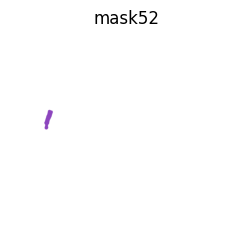

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


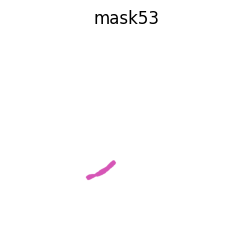

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


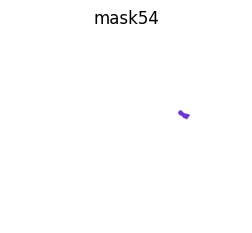

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


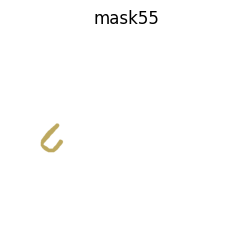

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


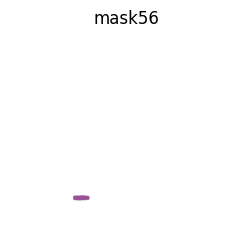

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


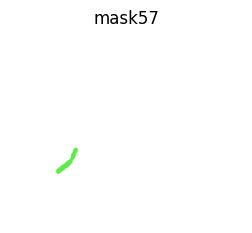

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


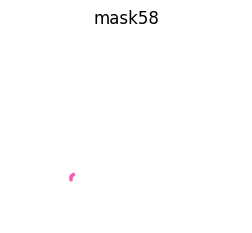

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


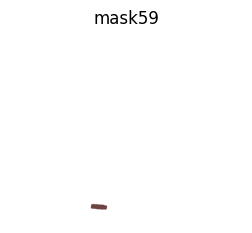

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


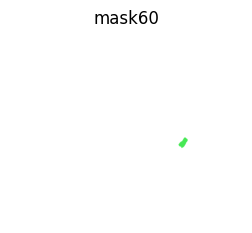

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


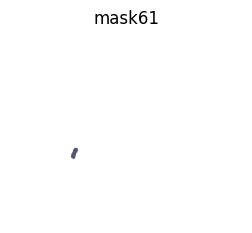

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


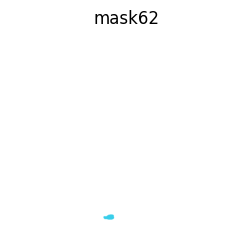

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


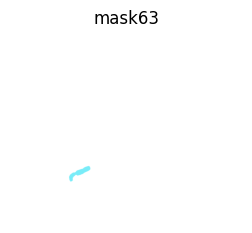

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


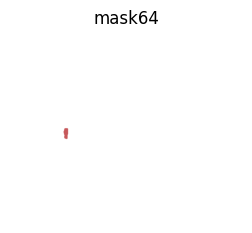

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


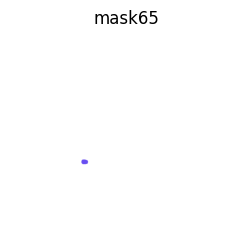

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


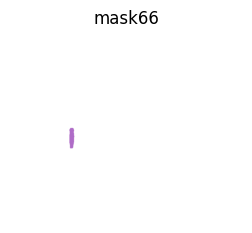

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


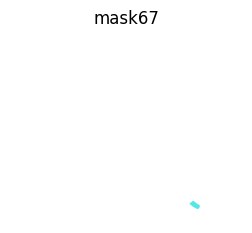

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


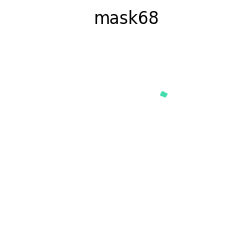

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


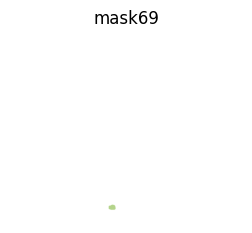

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


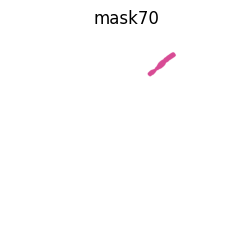

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


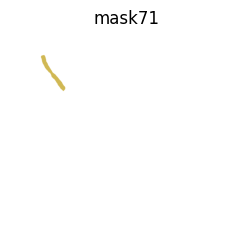

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


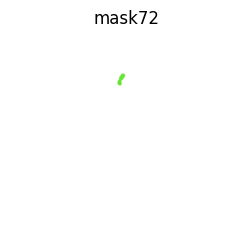

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


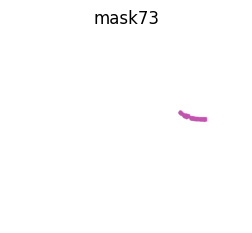

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


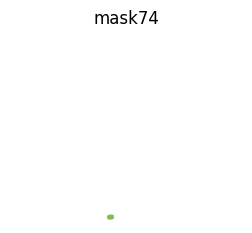

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


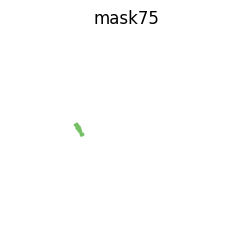

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


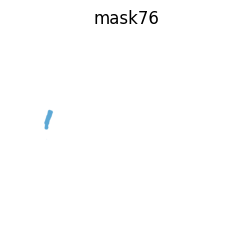

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


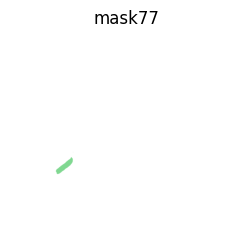

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


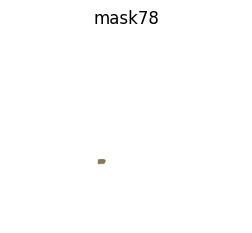

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


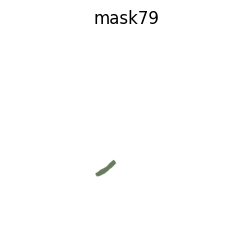

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


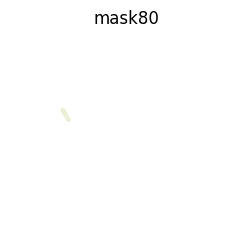

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


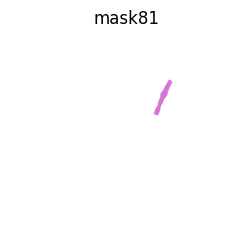

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


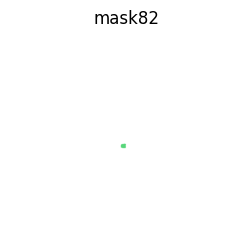

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


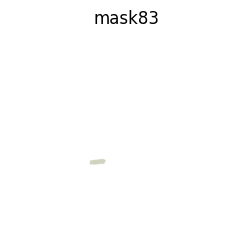

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


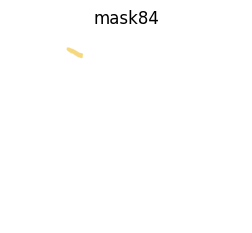

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


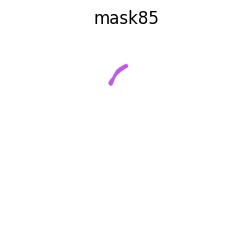

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


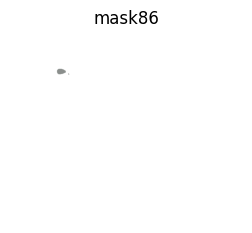

In [8]:
'''
    Abaixo, irei percorrer todas as máscaras geradas pelo algoritmo (acima), e depois, farei o "plotting" de cada uma das máscaras (POTENCIAIS CROMOSSOMOS)

    Como podemos ver no output, o algorítmo encontrou potenciais 123 CROMOSSOMOS (o que está errado).

    Este valor elevado se deve principalmente a imagem de baixa qualidade que usamos, através de uma análise das imagens abaixo (output),
    poderemos ver que o modelo está encontrando diversos "falsos cromossomos" em apenas 1 cromossomo.
'''

for i in range(len(masks1)):
    plt.figure(figsize=(3,3))
    plt.imshow(bgw)
    show_anns([masks1[i]])
    plt.title(f'mask{i}')
    plt.axis('off')  
    plt.show()

# Extração de retângulo da máscara

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask0 bbox: [431, 457, 564, 583]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\000.png


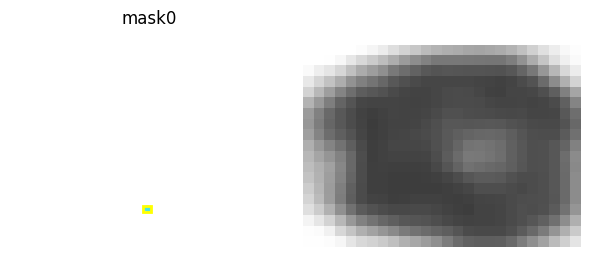

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask1 bbox: [323, 356, 344, 363]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\001.png


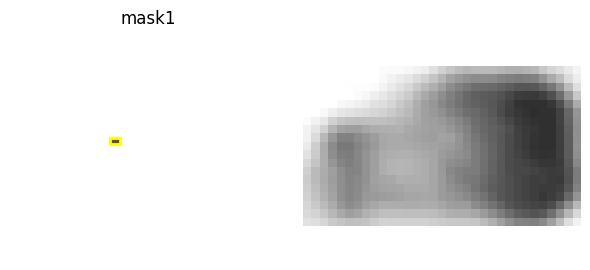

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask2 bbox: [395, 425, 557, 580]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\002.png


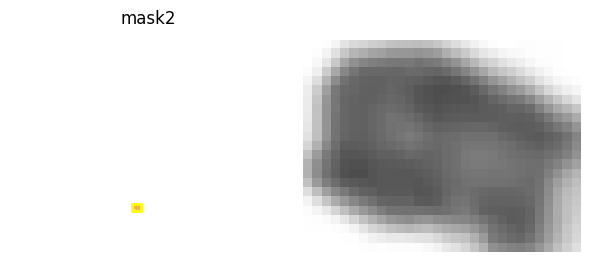

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask3 bbox: [244, 337, 634, 653]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\003.png


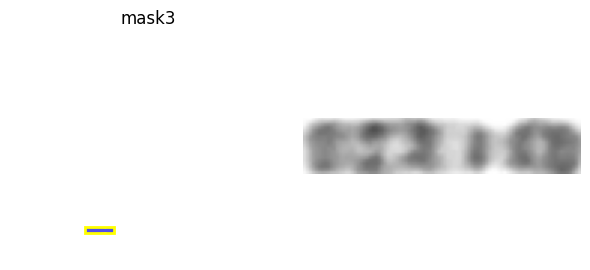

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask4 bbox: [370, 395, 434, 451]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\004.png


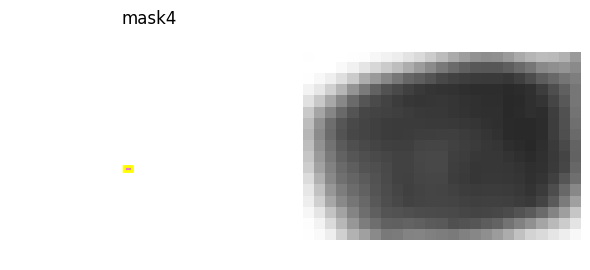

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask5 bbox: [422, 445, 164, 189]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\005.png


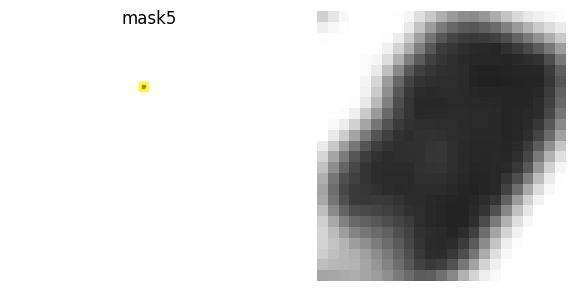

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask6 bbox: [331, 362, 572, 593]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\006.png


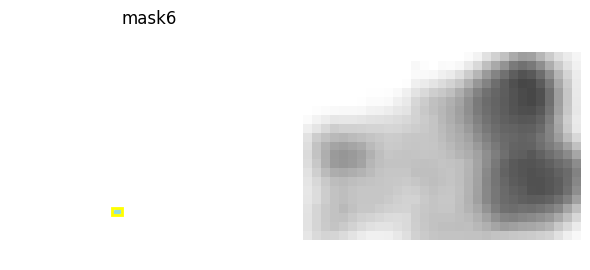

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask7 bbox: [276, 370, 494, 515]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\007.png


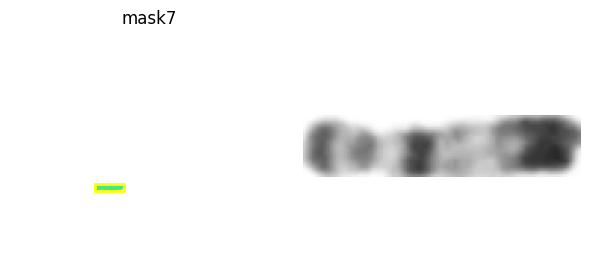

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask8 bbox: [380, 452, 601, 620]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\008.png


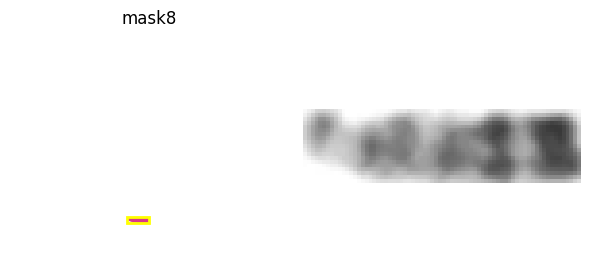

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask9 bbox: [513, 581, 487, 521]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\009.png


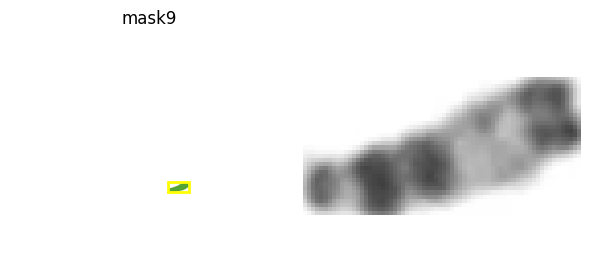

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask10 bbox: [313, 407, 667, 690]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\010.png


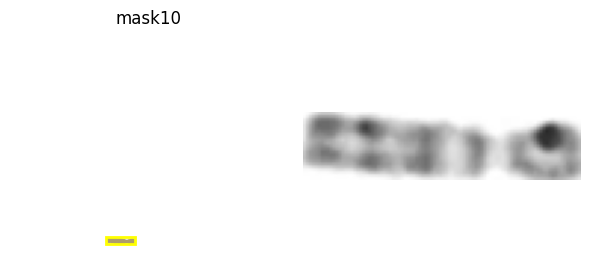

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask11 bbox: [538, 588, 344, 376]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\011.png


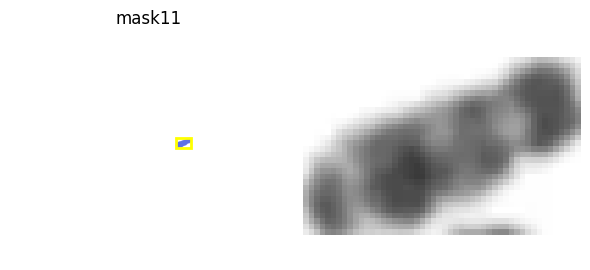

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask12 bbox: [692, 762, 328, 350]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\012.png


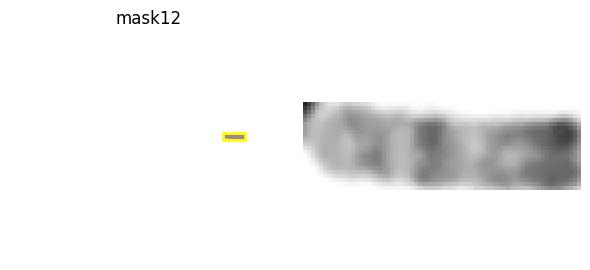

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask13 bbox: [309, 334, 181, 205]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\013.png


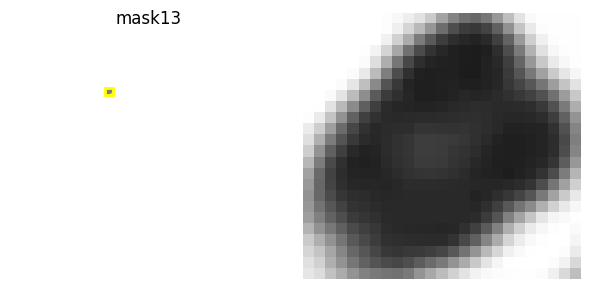

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask14 bbox: [680, 707, 85, 111]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\014.png


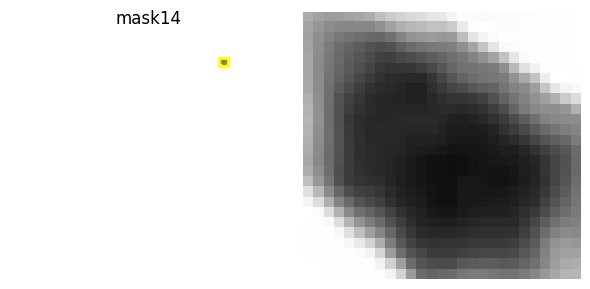

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask15 bbox: [568, 589, 397, 421]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\015.png


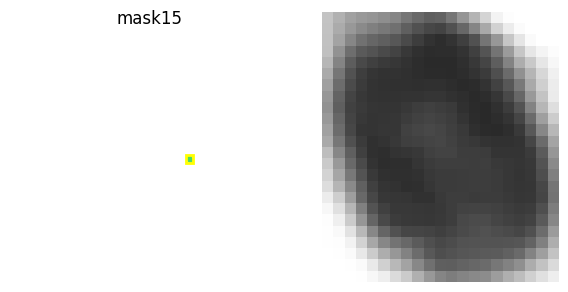

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask16 bbox: [395, 415, 421, 440]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\016.png


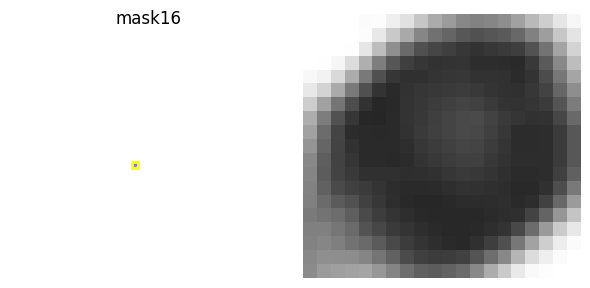

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask17 bbox: [534, 568, 546, 582]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\017.png


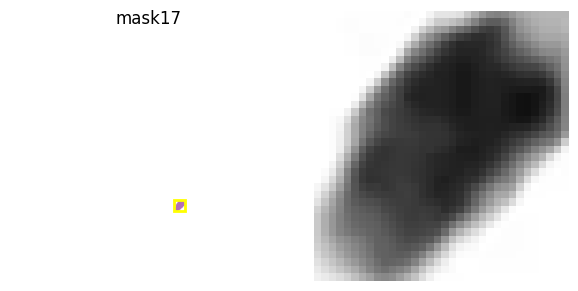

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask18 bbox: [463, 505, 644, 728]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\018.png


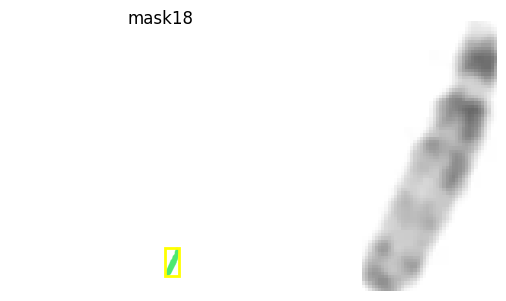

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask19 bbox: [370, 415, 421, 451]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\019.png


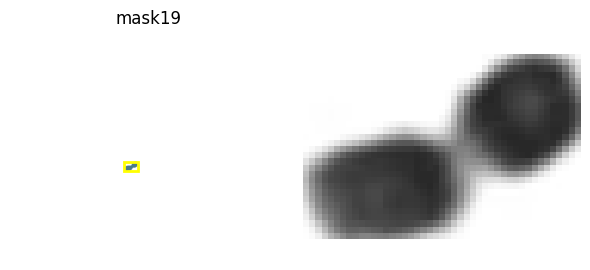

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask20 bbox: [538, 559, 276, 296]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\020.png


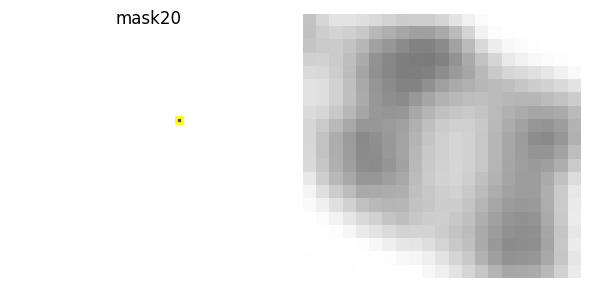

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask21 bbox: [255, 310, 521, 557]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\021.png


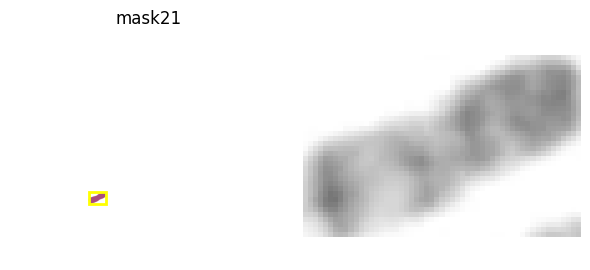

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask22 bbox: [514, 537, 263, 283]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\022.png


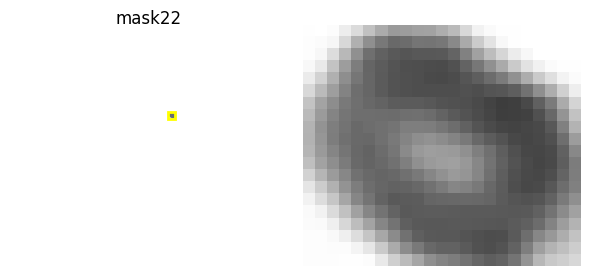

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask23 bbox: [91, 136, 145, 166]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\023.png


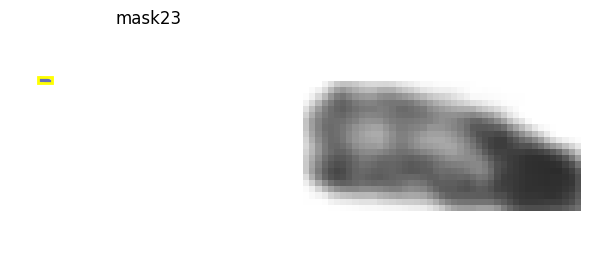

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask24 bbox: [312, 338, 634, 653]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\024.png


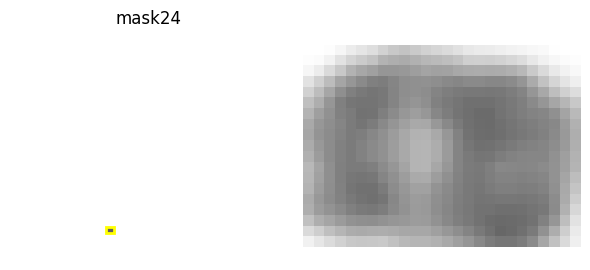

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask25 bbox: [381, 457, 127, 210]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\025.png


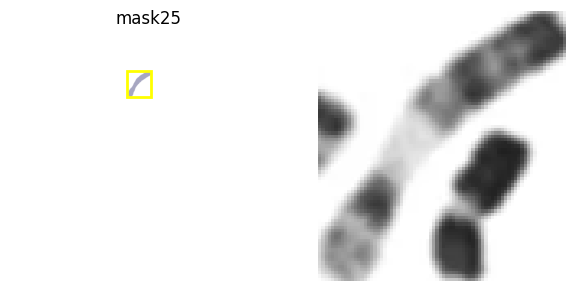

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask26 bbox: [665, 762, 52, 119]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\026.png


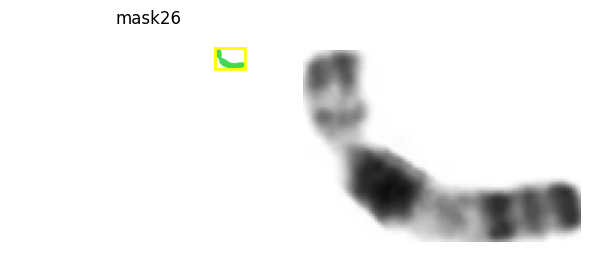

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask27 bbox: [87, 120, 222, 381]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\027.png


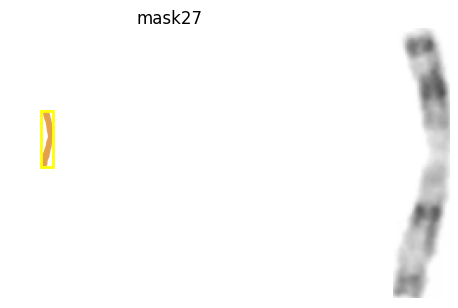

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask28 bbox: [678, 706, 639, 667]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\028.png


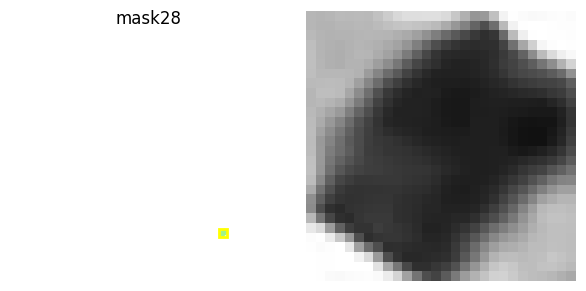

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask29 bbox: [640, 745, 214, 280]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\029.png


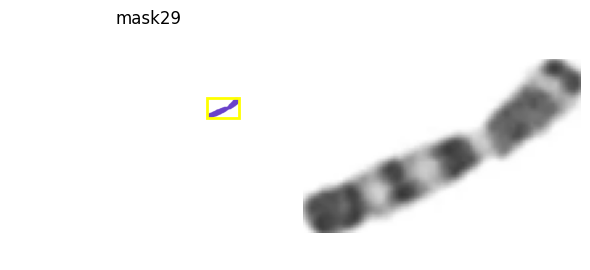

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask30 bbox: [395, 457, 557, 584]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\030.png


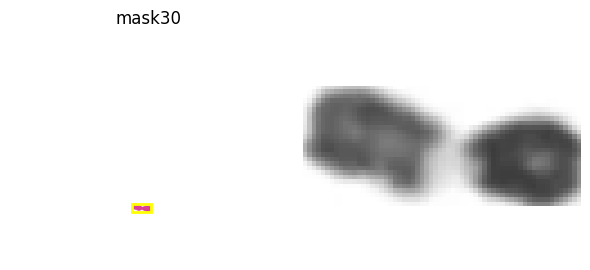

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask31 bbox: [515, 536, 198, 238]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\031.png


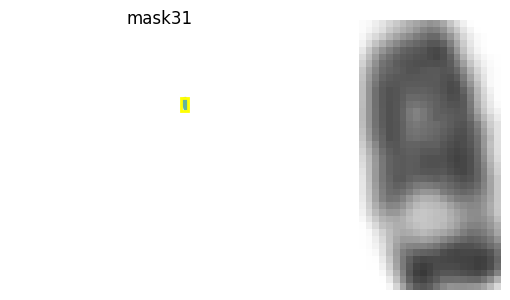

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask32 bbox: [610, 672, 308, 388]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\032.png


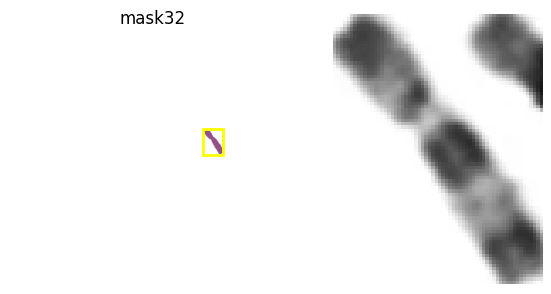

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask33 bbox: [188, 218, 51, 72]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\033.png


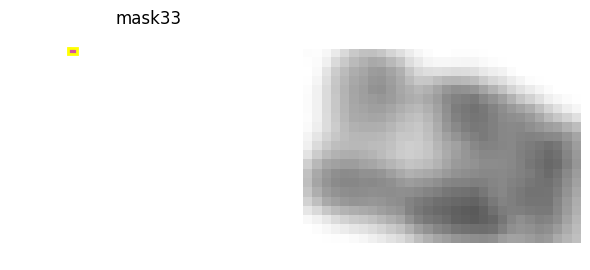

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask34 bbox: [278, 307, 201, 228]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\034.png


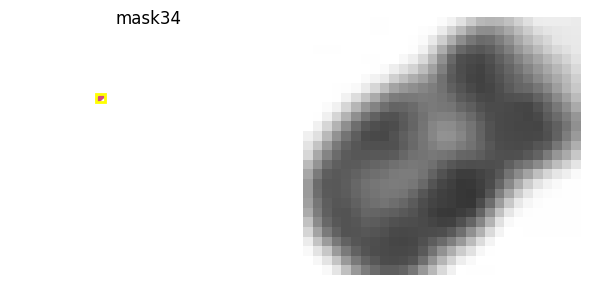

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask35 bbox: [655, 694, 505, 608]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\035.png


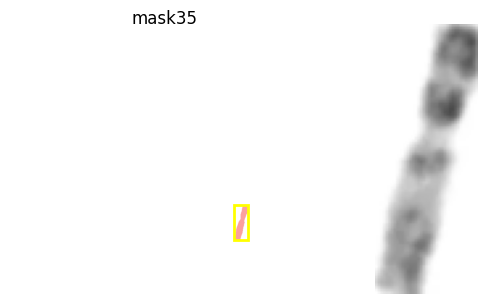

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask36 bbox: [499, 536, 127, 238]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\036.png


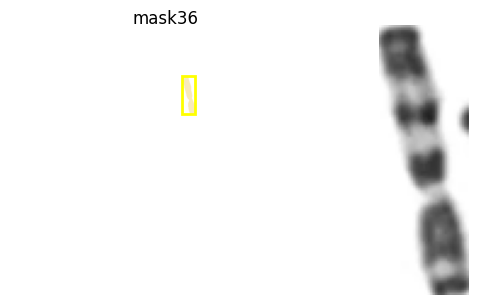

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask37 bbox: [275, 316, 342, 400]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\037.png


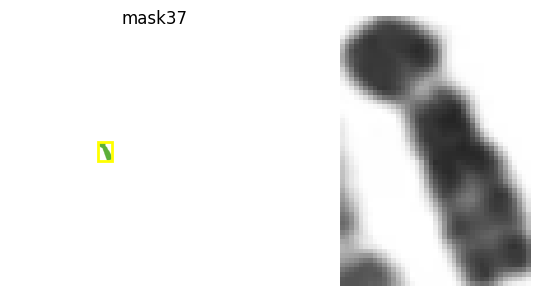

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask38 bbox: [188, 282, 51, 104]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\038.png


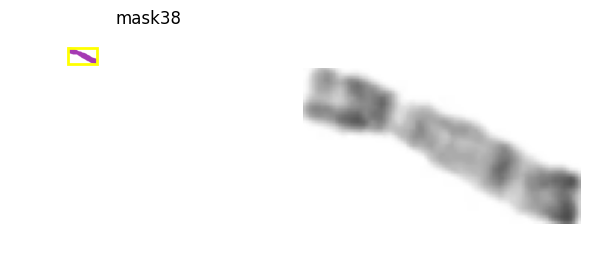

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask39 bbox: [514, 559, 263, 296]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\039.png


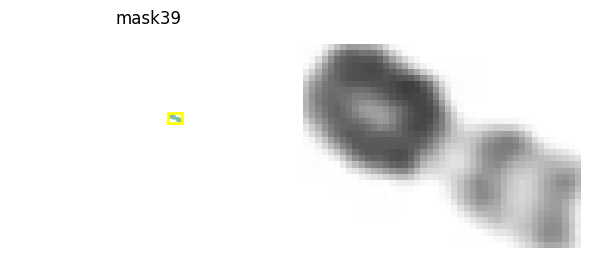

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask40 bbox: [490, 524, 441, 466]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\040.png


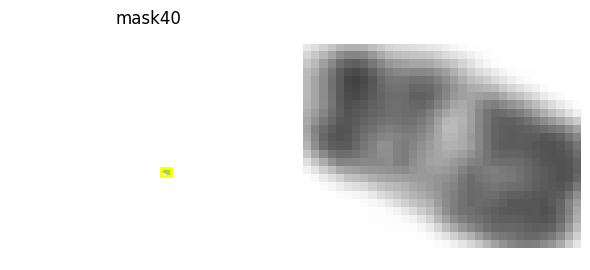

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask41 bbox: [562, 580, 375, 394]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\041.png


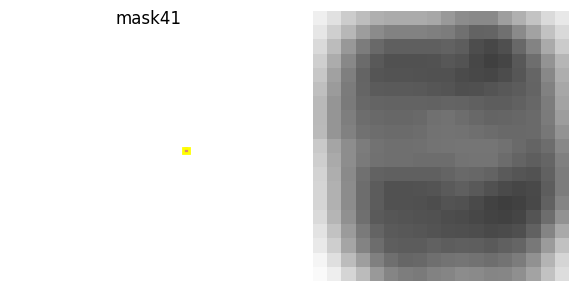

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask42 bbox: [498, 526, 127, 194]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\042.png


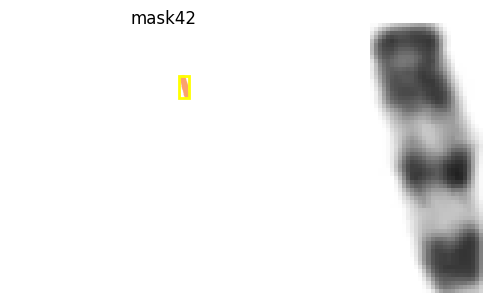

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask43 bbox: [295, 483, 265, 358]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\043.png


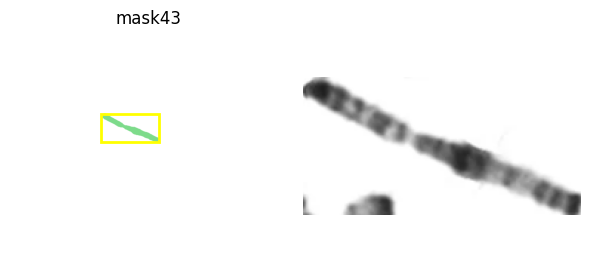

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask44 bbox: [261, 356, 136, 195]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\044.png


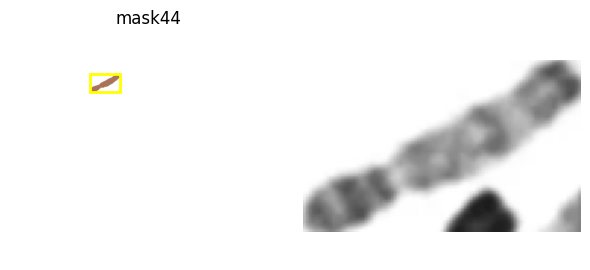

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask45 bbox: [600, 645, 563, 620]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\045.png


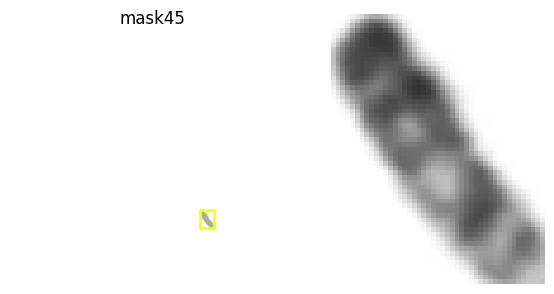

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask46 bbox: [709, 745, 214, 250]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\046.png


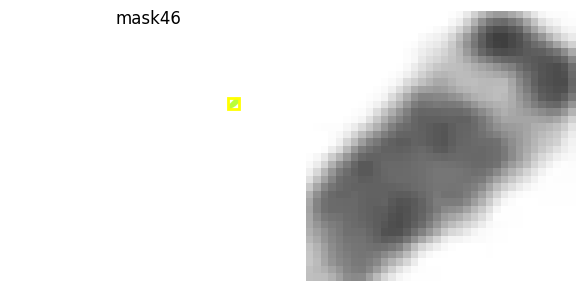

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask47 bbox: [429, 525, 434, 466]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\047.png


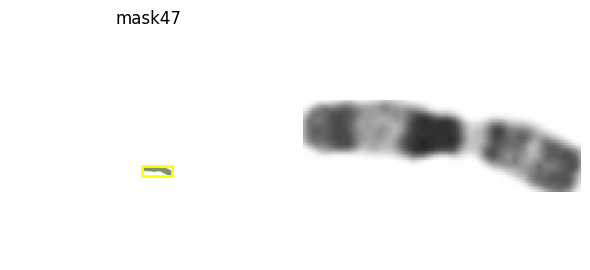

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask48 bbox: [461, 484, 437, 453]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\048.png


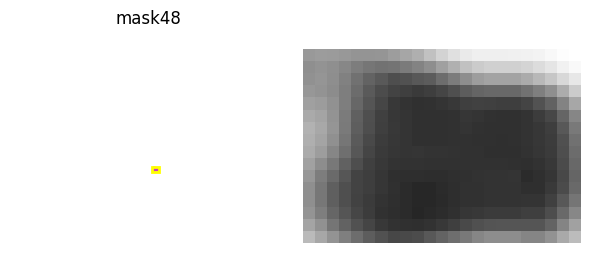

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask49 bbox: [91, 146, 145, 186]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\049.png


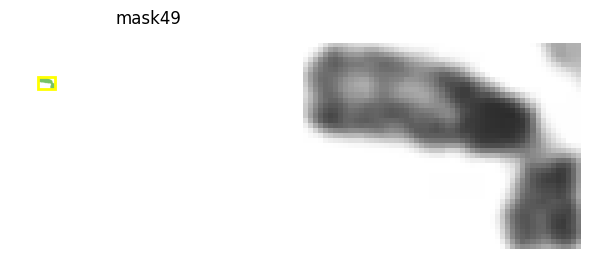

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask50 bbox: [562, 589, 374, 421]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\050.png


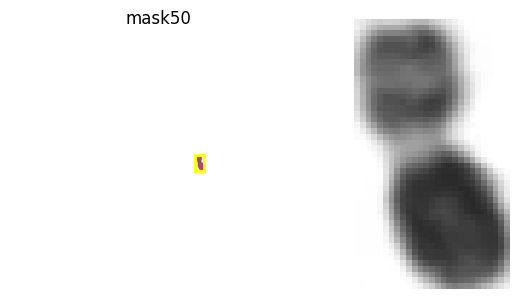

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask51 bbox: [288, 316, 356, 400]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\051.png


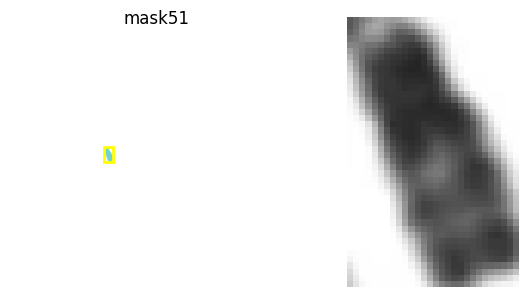

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask52 bbox: [133, 165, 304, 379]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\052.png


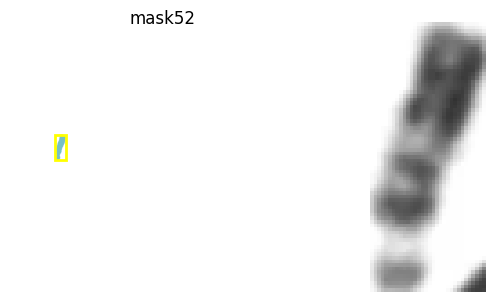

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask53 bbox: [294, 409, 499, 574]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\053.png


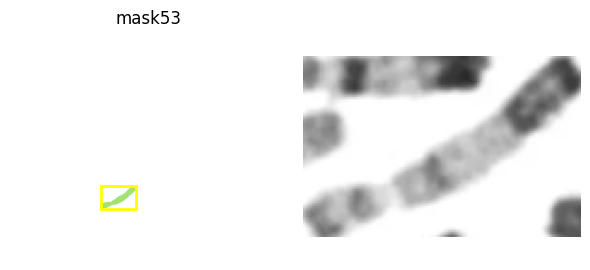

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask54 bbox: [651, 695, 306, 340]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\054.png


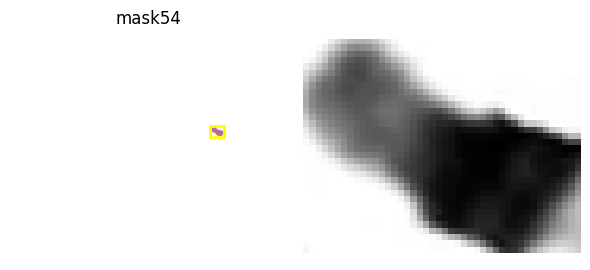

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask55 bbox: [119, 204, 357, 467]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\055.png


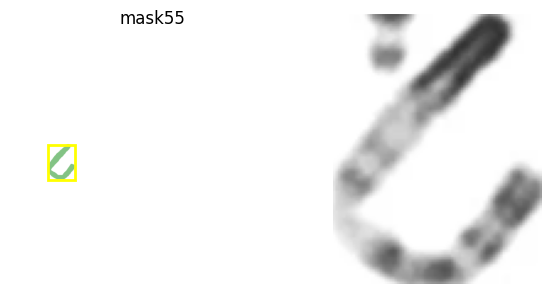

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask56 bbox: [244, 307, 634, 653]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\056.png


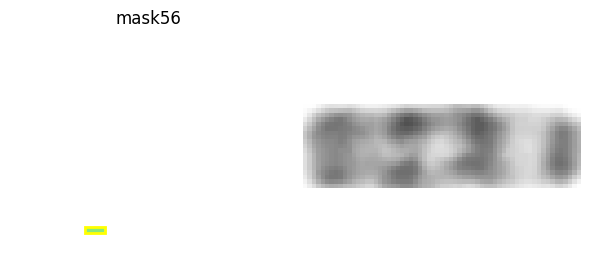

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask57 bbox: [178, 262, 451, 551]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\057.png


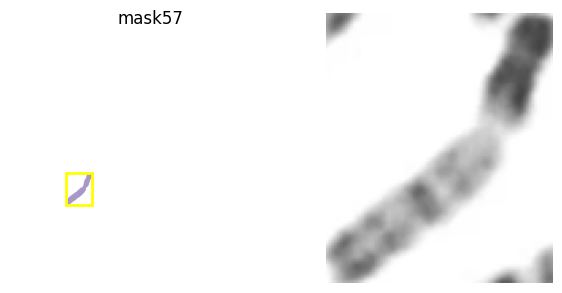

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask58 bbox: [229, 251, 547, 580]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\058.png


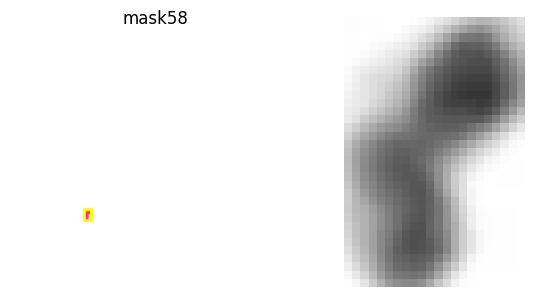

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask59 bbox: [313, 375, 668, 688]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\059.png


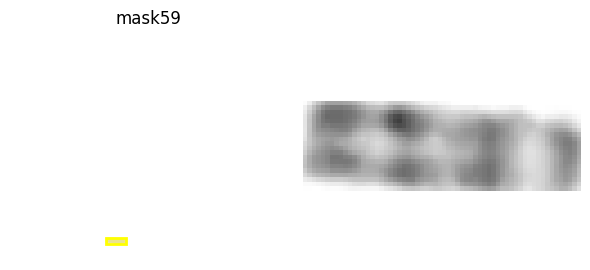

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask60 bbox: [652, 687, 411, 451]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\060.png


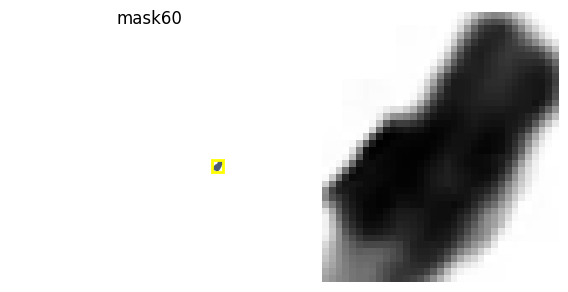

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask61 bbox: [236, 262, 451, 493]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\061.png


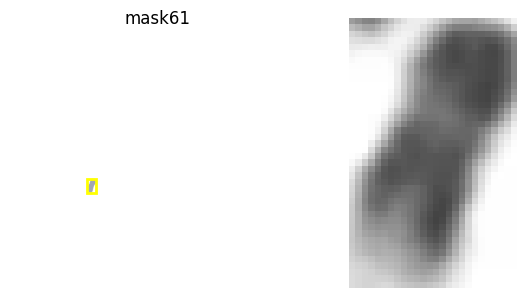

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask62 bbox: [362, 402, 708, 727]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\062.png


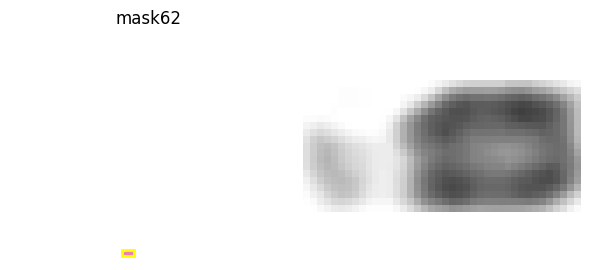

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask63 bbox: [229, 310, 521, 580]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\063.png


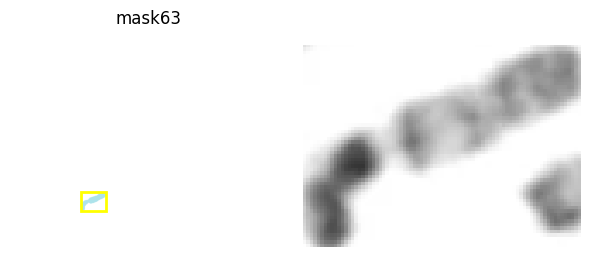

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask64 bbox: [207, 224, 375, 416]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\064.png


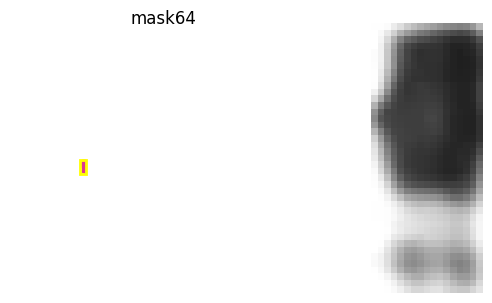

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask65 bbox: [276, 301, 496, 513]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\065.png


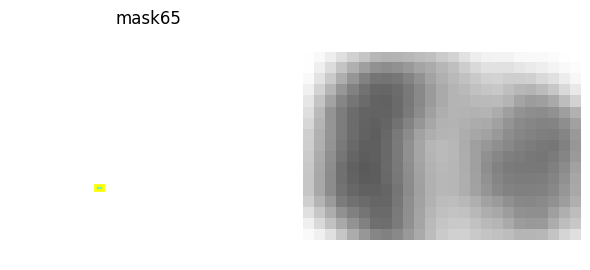

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask66 bbox: [230, 248, 374, 452]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\066.png


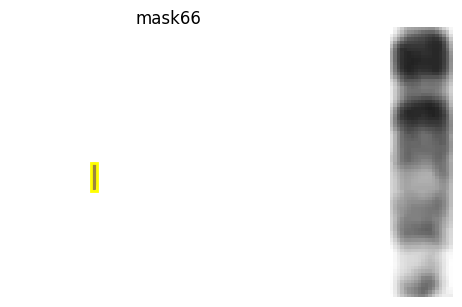

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask67 bbox: [695, 734, 656, 686]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\067.png


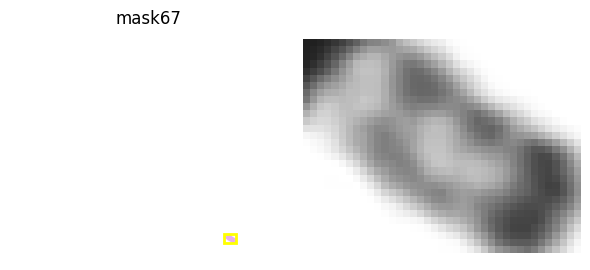

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask68 bbox: [581, 609, 232, 256]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\068.png


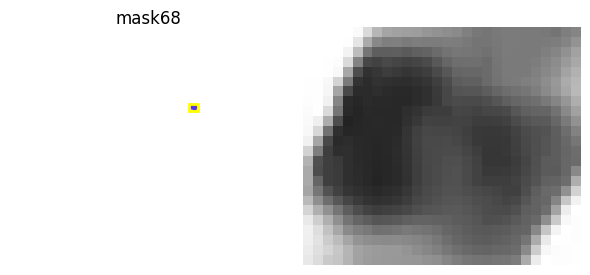

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask69 bbox: [382, 408, 670, 689]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\069.png


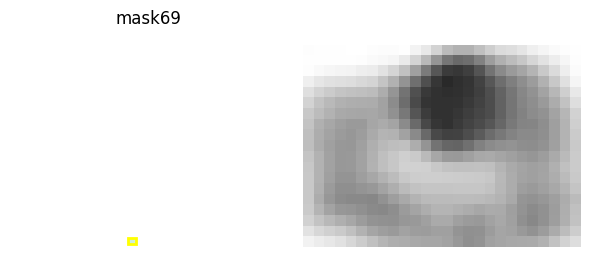

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask70 bbox: [533, 641, 82, 174]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\070.png


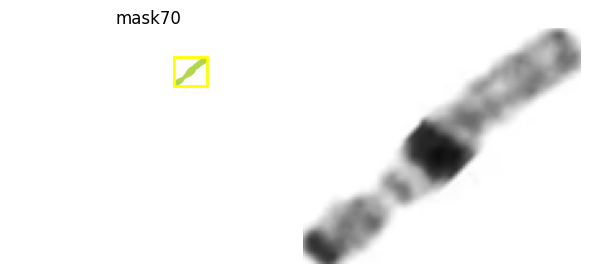

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask71 bbox: [120, 213, 93, 231]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\071.png


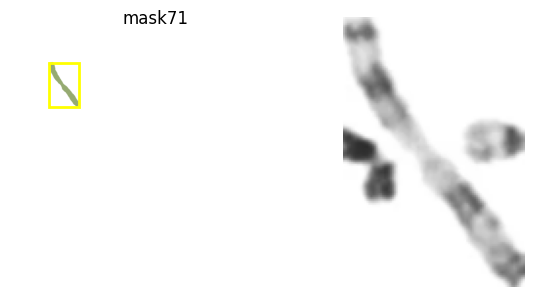

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask72 bbox: [416, 445, 164, 209]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\072.png


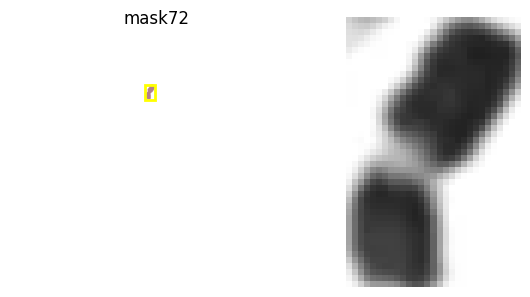

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask73 bbox: [651, 762, 306, 350]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\073.png


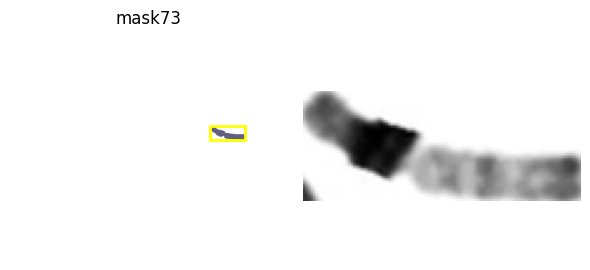

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask74 bbox: [376, 402, 708, 727]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\074.png


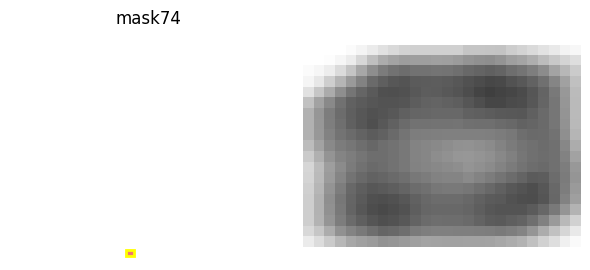

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask75 bbox: [246, 287, 353, 407]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\075.png


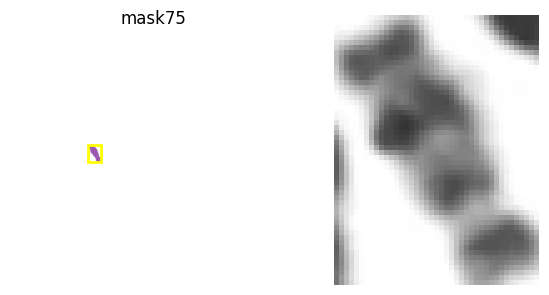

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask76 bbox: [133, 165, 304, 417]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\076.png


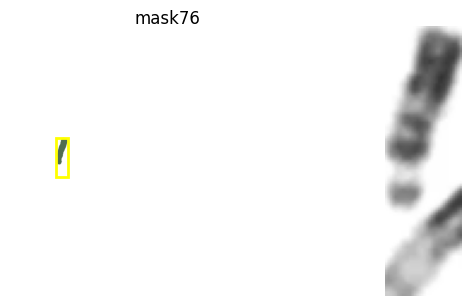

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask77 bbox: [177, 244, 467, 551]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\077.png


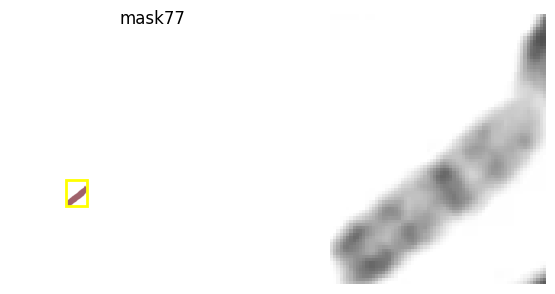

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask78 bbox: [340, 370, 494, 513]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\078.png


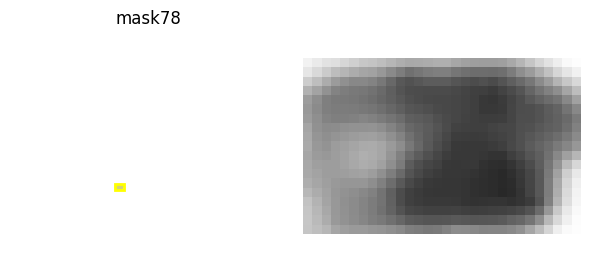

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask79 bbox: [331, 409, 498, 560]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\079.png


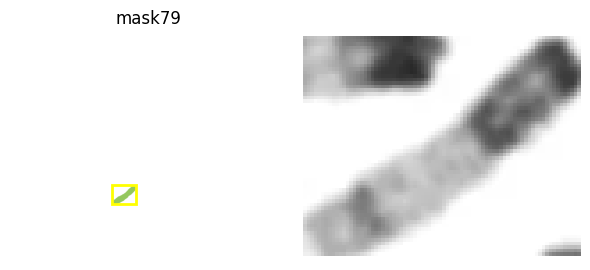

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask80 bbox: [195, 233, 297, 358]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\080.png


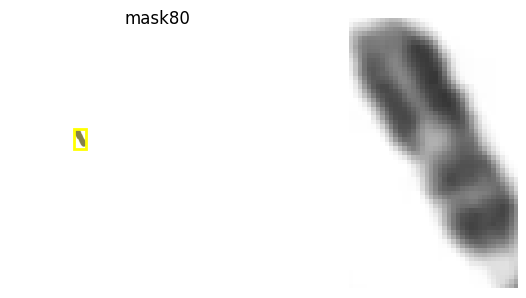

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask81 bbox: [557, 627, 188, 325]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\081.png


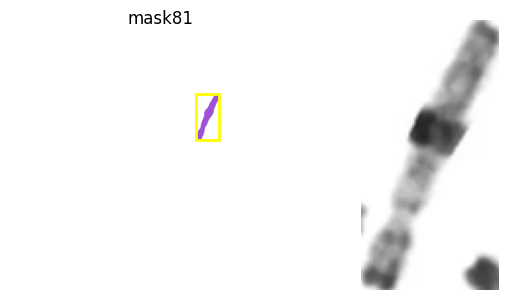

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask82 bbox: [429, 448, 435, 451]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\082.png


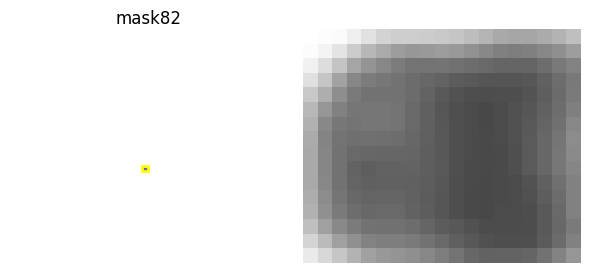

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask83 bbox: [308, 369, 494, 515]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\083.png


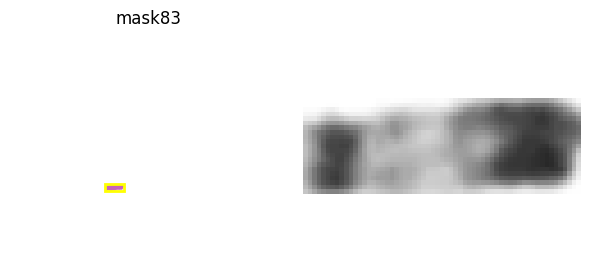

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask84 bbox: [219, 282, 63, 104]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\084.png


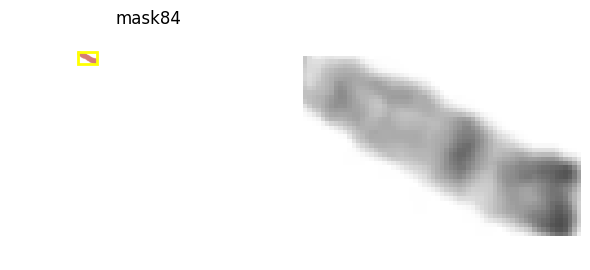

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask85 bbox: [347, 457, 127, 213]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\085.png


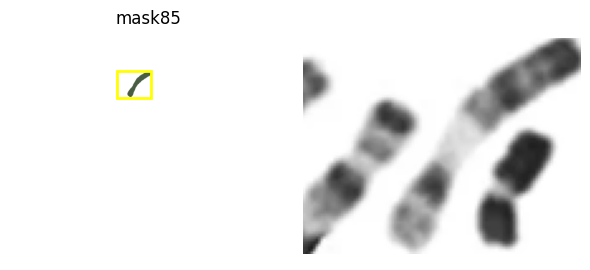

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask86 bbox: [182, 228, 146, 168]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo2\086.png


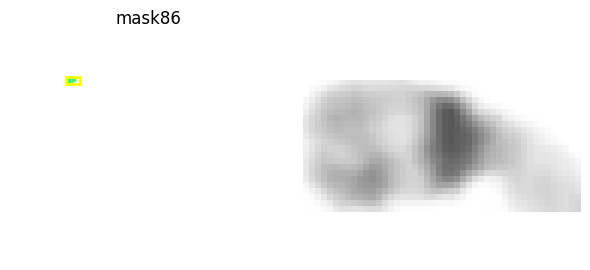

In [9]:
'''
    Com as máscaras obtidas anteriormente, é possível plottarmos retângulos de identificação em cada cromossomo identificado pelo modelo.
    Após realizarmos os "recortes", as imagens serão salvas na pasta "/recortes/"
    Como podemos ver a seguir:
'''

# Criação da pasta recortes
os.makedirs('recortes/ITChromo-Leo2', exist_ok=True)

# Itera pelas máscaras
for i in range(len(masks1)):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].imshow(bgw)
    masksi = masks1[i]
    xc, yc, w, h = masksi['bbox']
    x0, y0, x1, y1 = int(xc), int(yc), int(xc + w), int(yc + h)

    print(f'mask{i} bbox: {[x0, x1, y0, y1]}')

    # Recorte da imagem original
    boximage = image[y0:y1, x0:x1, :]

    # Caminho absoluto para salvar
    save_path = os.path.abspath(os.path.join('recortes/ITChromo-Leo2', f'{str(i).zfill(3)}.png'))
    print(f"Imagem salva em em: {save_path}")

    # Salva o recorte
    cv2.imwrite(save_path, cv2.cvtColor(boximage, cv2.COLOR_RGB2BGR))

    # Exibição
    rect = patches.Rectangle((xc, yc), w, h, linewidth=2, edgecolor='yellow', fill=False)
    show_anns([masksi], ax[0])
    ax[0].add_patch(rect)
    ax[1].imshow(boximage)
    ax[0].set_title(f'mask{i}')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
'''
    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.
    Também observa-se um tempo de resposta MUITO MENOR.

    Antes -> Identificação de 123 cromossomos em aprox. 6 minutos            (tempo de identificação + plottagem gráfica)
    Depois -> Identificação de 85 cromossomos em aprox. 1 minutos.           (tempo de identificação + plottagem gráfica)
'''

'\n    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.\n    Também observa-se um tempo de resposta MUITO MENOR.\n\n    Antes -> Identificação de 79 cromossomos em aprox. 4 minutos            (tempo de identificação + plottagem gráfica)\n    Depois -> Identificação de 50 cromossomos em aprox. 47 segundos.        (tempo de identificação + plottagem gráfica)\n'